# Generating Adverserial Networks

## Basic Definitions 

- A <b>generative model</b> tries to learn the joint probability of the input data and labels simultaneously, i.e. <b>P(x,y)</b>. This can be converted to <b>P(y|x)</b> for classification via Bayes rule, but the generative ability could be used for something else as well, such as creating likely new <b>(x,y)</b> samples.


- A <b>discriminative model</b> learns a function that maps the input data <b>(x)</b> to some desired output class label <b>(y)</b>. In probabilistic terms, they directly learn the conditional distribution <b>P(y|x)</b>.

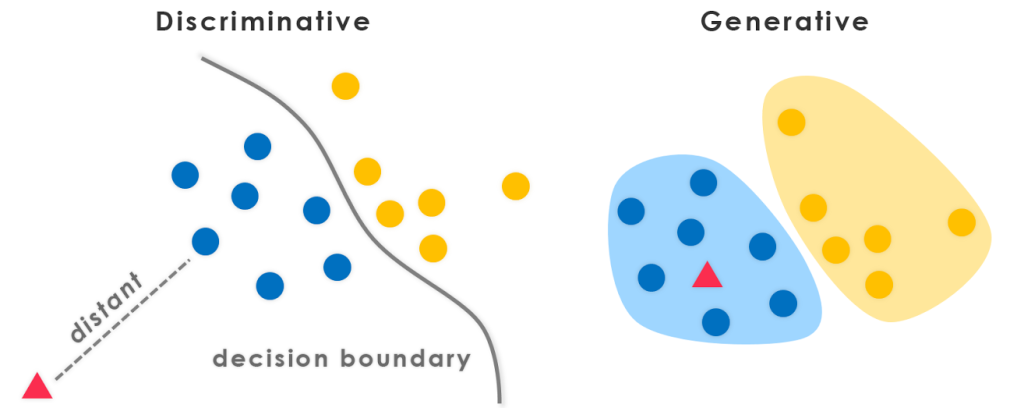

- <b> MiniMax Game Play <b>

    function minimax(node, depth, maximizingPlayer)
         if depth = 0 or node is a terminal node
             return the heuristic value of node

         if maximizingPlayer
            bestValue := −∞
             for each child of node
                 v := minimax(child, depth − 1, FALSE)
                 bestValue := max(bestValue, v)
             return bestValue

         else    (* minimizing player *)
             bestValue := +∞
             for each child of node
                 v := minimax(child, depth − 1, TRUE)
                 bestValue := min(bestValue, v)
             return bestValue


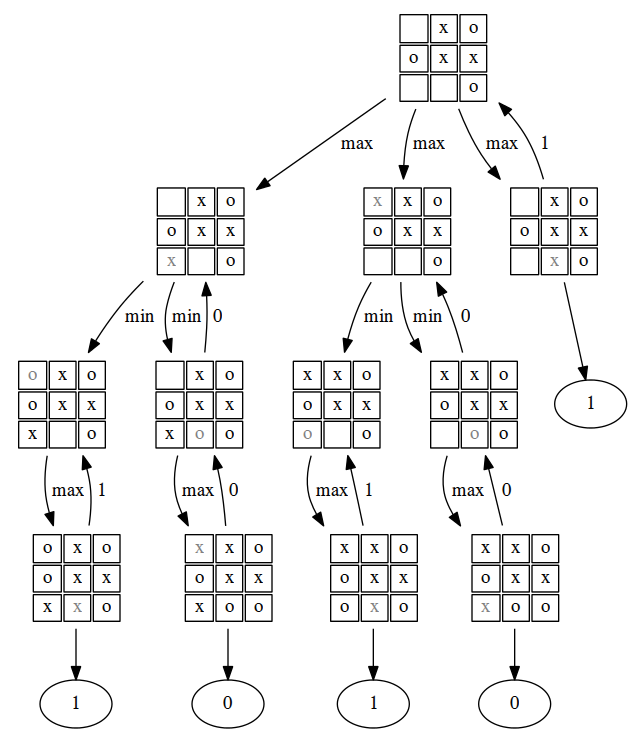

## Problems with existing Generative Deep learning Models 

- The progress in generative network models is far behind the discriminative deep models(CNN object classification .etc). Primarily because it is easier to form complicated piecewise linear boundaries in comparison to intrinsically learning probabilty distributions of the training dataset. (Something that is done by methods like EM, maximum likelyhood etc.)  

## Adverserial Nets 

Adverserial nets splits training into an adverserial minimax zero sum game between a Generative model and an adverserial model.

- The generative model generates data to resemble the given dataset. Its goal is to maximise the probabilty of its generated data points to be classified as true data points by the discriminator.

- The Discriminator model on the other hand optimises to maximise the probabilty of classifying the generated data points as "fake" and real data points as  "True" values.

- The competition between the two helps improve the quality of the generator in generating data points that resemble the true data points. And the discriminating power of the discriminator to classify generated datapoints as "Fake" and true data points as "True". 

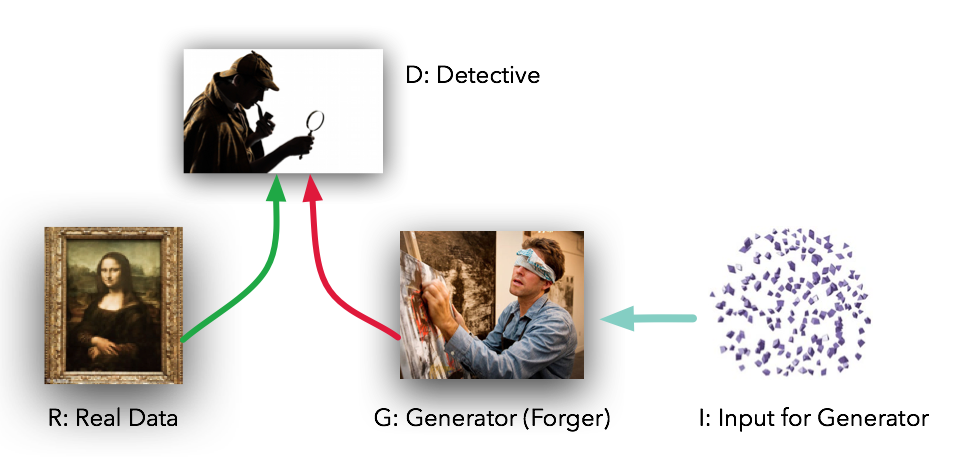

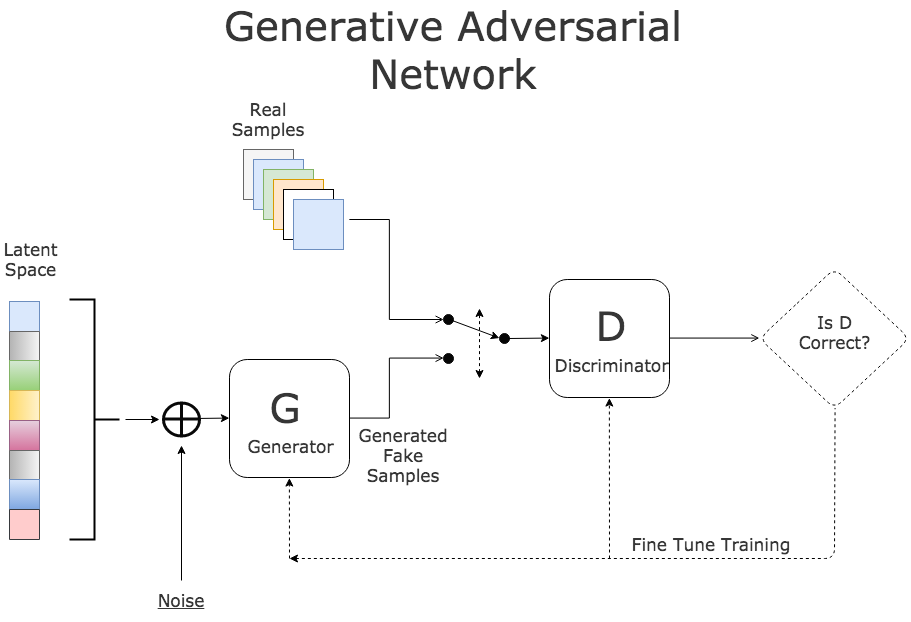

The <b>Latent space</b> is just a noise sampled from a uniform distribution,matched to the dimensions of the data vectors (or their representtion in the network)

The discriminator outputs a value <b>D(x)</b> indicating the chance that x is a real image. We define an objective function <b>V</b> below for the discriminator to maximize the chance of classifying images correctly. We use cross-entropy (as in most deep learning), <i>log(q)</i>, to compute the loss, i.e. maximizes the likelihood of the observed data.

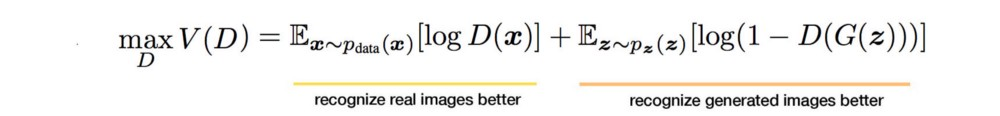

On the generator side, its objective function wants the model to generate images with the highest possible value of <b>D(x)</b> to fool the discriminator.

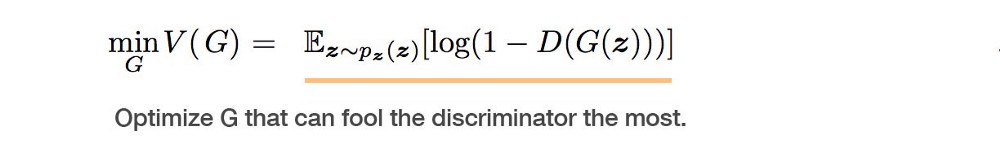

We often define GAN as a minimax game which G wants to minimize V while D wants to maximize it.

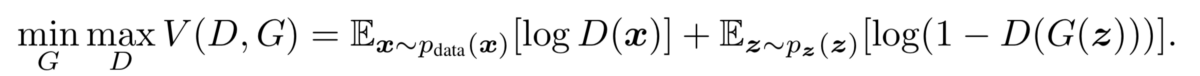

Once both objective functions are defined, they are learned jointly by the alternating gradient descent. We fix the generator model’s parameters and perform a single iteration of gradient descent on the discriminator using the real and the generated images. Then we switch sides. Fix the discriminator and train the generator for another single iteration. We train both networks in alternating steps until the generator produces good quality images. The following summarizes the data flow and the gradients used for the backpropagation.

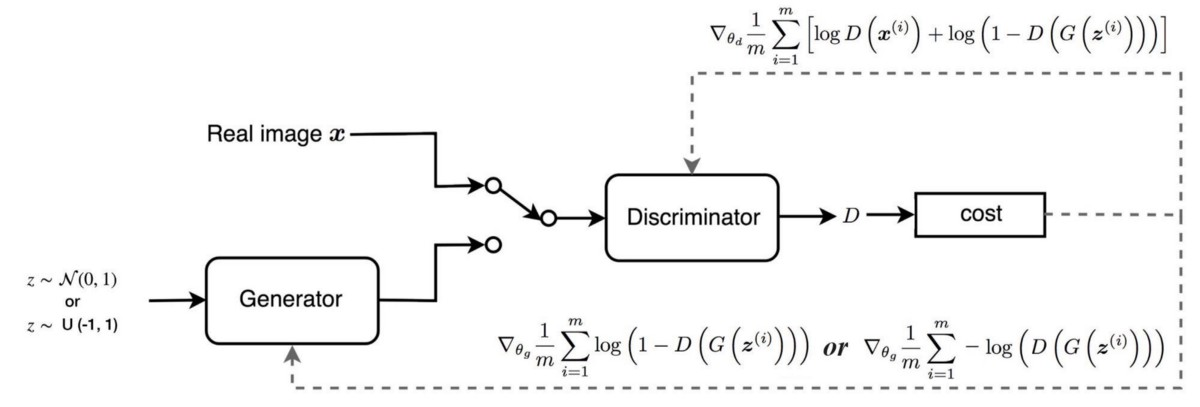

The pseudo code below puts everything together and shows how GAN is trained

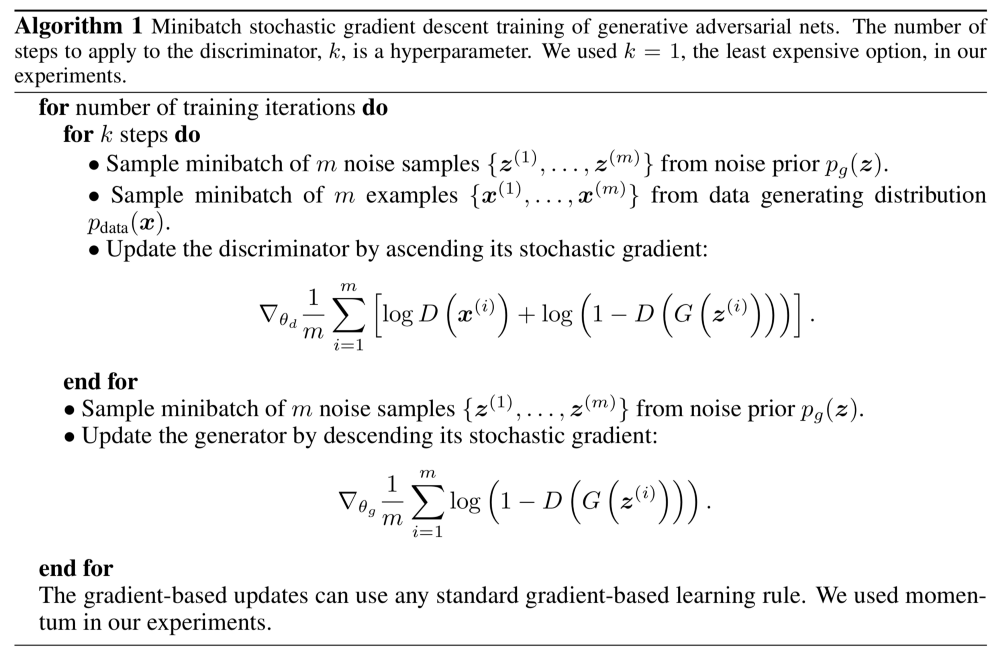

## Making a GAN that learns a Gussian 

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### Input Data (Gussian Distribution) : R

In our case, we’ll start with the simplest possible input data — a bell curve. This function takes a mean and a standard deviation and returns a function which provides the right shape of sample data from a Gaussian with those parameters. In our sample code, we’ll use a mean of 4.0 and a standard deviation of 1.25.

In [24]:
# Data params
data_mean = 4
data_stddev = 1.25

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

### Input Noise for the Generator : I

The input into the generator is also random, but to make our job a little bit harder, let’s use a uniform distribution rather than a normal one. This means that our model G can’t simply shift/scale the input to copy R, but has to reshape the data in a non-linear way.

In [13]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

### The Generator : G

The generator is a standard feedforward graph — two hidden layers, three linear maps. We’re using an ELU (exponential linear unit). G is going to get the uniformly distributed data samples from I and somehow mimic the normally distributed samples from R.

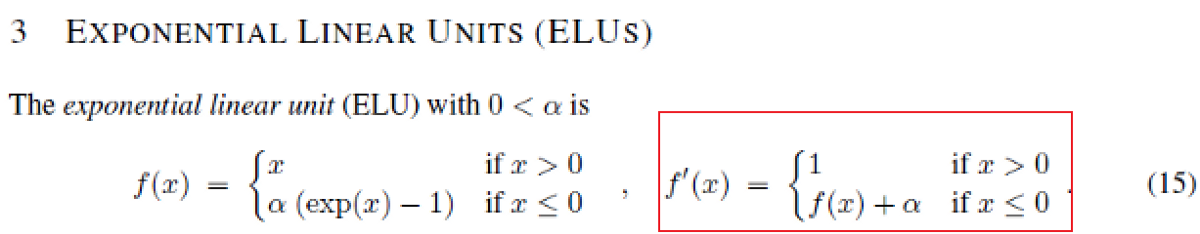

In [14]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

### The Discriminator : D

The discriminator code is very similar to G’s generator code; a feedforward graph with two hidden layers and three linear maps. It’s going to get samples from either R or G and will output a single scalar between 0 and 1, interpreted as ‘fake’ vs. ‘real’.

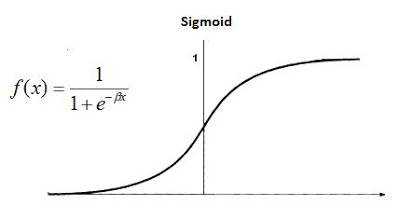

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

### Model Parameters

In [80]:
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#decorate_with_diffs,takes the existing raw distribution 
#and also adds the squared distance of each point from the mean 
#as extra information for the discriminator.
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))


Using data [Data and variances]


In [81]:
a = torch.randn(4, 4)
print('%d'%1,a.data)
#print('%d'%2,a[0].sum()/len(a[0]))
a_mean = torch.mean(a, 1, keepdim=True)
print('%d'%3,a_mean)
print('%d'%4,a.data.storage().tolist())
print('%d'%5,torch.ones(a.size()))
print('%d'%7,a_mean.tolist()[0][0])
mean_broadcast_a = torch.mul(torch.ones(a.size()), a_mean.tolist()[0][0])
print('%d'%8,mean_broadcast_a)
diffs_a = torch.pow(a - Variable(mean_broadcast_a), 2)
print('%d'%9,diffs_a)
a_return = torch.cat([a, diffs_a], 1)
print('%d'%10,a_return)

1 tensor([[-0.3206, -0.6756, -0.0109, -0.5018],
        [-0.2298, -0.2352, -0.2186,  0.8888],
        [-1.1281, -1.4736,  0.8370, -0.7530],
        [ 1.0512, -0.5602, -0.8250, -0.4614]])
3 tensor([[-0.3772],
        [ 0.0513],
        [-0.6294],
        [-0.1988]])
4 [-0.3206014335155487, -0.6756151914596558, -0.010943074710667133, -0.5017583966255188, -0.22976404428482056, -0.23524808883666992, -0.2185904085636139, 0.888753354549408, -1.1280909776687622, -1.4735887050628662, 0.8369802832603455, -0.7530264258384705, 1.0511908531188965, -0.5601528882980347, -0.8250207901000977, -0.4614078402519226]
5 tensor([[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.]])
7 -0.3772295117378235
8 tensor([[-0.3772, -0.3772, -0.3772, -0.3772],
        [-0.3772, -0.3772, -0.3772, -0.3772],
        [-0.3772, -0.3772, -0.3772, -0.3772],
        [-0.3772, -0.3772, -0.3772, -0.3772]])
9 tensor([[ 0.0032,  0.0890,  0.1342,  0.0155],
        [ 0.021

In [82]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)


In [84]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        #We give the discriminator real data as d_rel_data,it is 100 samples taken from normal distribution
        d_real_data = Variable(d_sampler(d_input_size))
        #The discriminator then outputs value bw [0,1], 0: fake, 1: Real, as d_real_decision
        d_real_decision = D(preprocess(d_real_data))
        #d_real_error is Binary cross entropy loss, x is the decision that D makes, 1 is the decision it should
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        #generate 100 uniformly distributed points (fake sample) as d_gen_input
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        #get fake_data from generator(generator is learning to creat true data from input noise)
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        #make deciion on the fake data
        d_fake_decision = D(preprocess(d_fake_data.t()))
        #calculate BCE on fake data,labeling it as one 
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()
        #Noise input
        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        #generating fakes from noise
        g_fake_data = G(gen_input)
        #get D's opinion on G's data
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        #calculate BCE, for making fake_data classified as true, i.e. 1 
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("Epoch: %s (Real: %s, Fake: %s) " % (epoch,   
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



/Users/sagarmalhotra/anaconda3/envs/aind/lib/python3.5/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 0 (Real: [3.8615887749195097, 1.1552568031544117], Fake: [-0.17722486943006516, 0.026136091721321426]) 
Epoch: 200 (Real: [3.750509645938873, 1.3916939539309807], Fake: [-0.38520127177238467, 0.021708685472849227]) 
Epoch: 400 (Real: [3.959439167976379, 1.2933200058026115], Fake: [-0.5181425166130066, 0.045906980857065585]) 
Epoch: 600 (Real: [3.8520762914419175, 1.2311649919239593], Fake: [-0.5132055161893367, 0.20903465013041717]) 
Epoch: 800 (Real: [4.142819048166275, 1.2042850502440816], Fake: [0.015827311761677267, 0.5408860934696753]) 
Epoch: 1000 (Real: [4.074258550405502, 1.2853389119282628], Fake: [1.373999084085226, 0.7014970488093707]) 
Epoch: 1200 (Real: [3.901369121670723, 1.1425596544678807], Fake: [2.5635527691245077, 1.2993253591648397]) 
Epoch: 1400 (Real: [3.8608138400316236, 1.2914707759337518], Fake: [3.6210923945903777, 1.420762194106712]) 
Epoch: 1600 (Real: [4.131296385526657, 1.30019282639685], Fake: [4.52436359167099, 1.4537052087792934]) 
Epoch: 1800 (R

Epoch: 15200 (Real: [4.039231139719487, 1.2419814319638394], Fake: [3.977047294974327, 0.9966973833753301]) 
Epoch: 15400 (Real: [3.969261909723282, 1.199919515600643], Fake: [4.0128549990057945, 1.292133034734821]) 
Epoch: 15600 (Real: [4.104809285402298, 1.2549350088130056], Fake: [4.181522656679153, 1.2050665389122988]) 
Epoch: 15800 (Real: [3.8101577770709993, 1.0920035774806316], Fake: [4.351564447283745, 1.1674752406154119]) 
Epoch: 16000 (Real: [3.8093996095657348, 1.2319513559020372], Fake: [4.323454095125198, 1.106509578985051]) 
Epoch: 16200 (Real: [4.085293818712234, 1.2403042815895928], Fake: [3.990392034649849, 1.3155859613837675]) 
Epoch: 16400 (Real: [3.861721859574318, 1.1989156449986478], Fake: [4.3508526754379275, 1.1068461473475673]) 
Epoch: 16600 (Real: [4.137648733854294, 1.307492828093901], Fake: [4.216229288578034, 1.102253331867863]) 
Epoch: 16800 (Real: [4.141727210283279, 1.2641105732871571], Fake: [4.1841028958559034, 1.215783308957662]) 
Epoch: 17000 (Real: 